In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import re
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [2]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
print("Count of NaN data in every column:")
train_df.isna().sum()

Count of NaN data in every column:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
def fix_Name(df):
    titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    rare = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']    
    df['Title'] = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace(rare,'Rare')
    df['Title'] = df['Title'].map(titles)
    df['Title'] = df['Title'].fillna(0)
    return df

In [9]:
def new_Features(df):
    df['AgeClass'] = df.loc[:,'Age']*df.loc[:,'Pclass']
    df['SexAge'] = df.loc[:,'Sex']*df.loc[:,'Age']
    df["FamilySize"] = df["SibSp"]+df["Parch"]+1
    return df

In [10]:
def fix_Sex(df):
    df.loc[df['Sex'].isnull(), 'Sex'] = np.random.randint(0,2)
    genders = {"male": 0, "female": 1}
    df['Sex'] = df['Sex'].map(genders)
    df['Sex'] = df['Sex'].astype(int)
    return df

In [11]:
def fix_Age(df):
    mean = df["Age"].mean()
    std = df["Age"].std()
    is_null = df["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    df.loc[df['Age'].isnull(), 'Age'] = rand_age
    df['Age'] = df['Age'].astype(int)
    return df

In [12]:
def fix_Fare(df):
    df.loc[df['Fare'].isnull(), 'Fare'] = 0
    df['Fare'] = df['Fare']/df['Fare'].mean()
    #df['Fare'] = df['Fare'].astype(int)
    return df

In [13]:
def fix_Cabin(df):
    deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    df['Cabin'] = df['Cabin'].fillna("U0")
    df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    df['Deck'] = df['Deck'].map(deck)
    df['Deck'] = df['Deck'].fillna(0)
    df['Deck'] = df['Deck'].astype(int)
    return df

In [14]:
def fix_Embarked(df):
    ports = {"S": 0, "C": 1, "Q": 2}
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map(ports)
    return df

In [15]:
def rm(df):
    df = df.drop(['PassengerId'], axis=1)
    df = df.drop(['Name'], axis=1)
    df = df.drop(['Ticket'], axis=1)
    df = df.drop(['Cabin'], axis=1)
    return df

In [16]:
def data_train_pp(df):
    df = fix_Name(df)
    df = fix_Sex(df)
    df = fix_Age(df)
    df = fix_Cabin(df)
    df = fix_Fare(df)
    df = fix_Embarked(df)
    df = new_Features(df)
    df = rm(df)
    df = df.drop(['Survived'], axis=1)
    return df

In [17]:
def data_test_pp(df):
    df = fix_Sex(df)
    df = fix_Fare(df)
    df = fix_Age(df)
    df = fix_Cabin(df)
    df = fix_Name(df)
    df = fix_Embarked(df)
    df = new_Features(df)
    df = rm(df)
    return df

In [18]:
train_x = data_train_pp(train_df)
train_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,AgeClass,SexAge,FamilySize
0,3,0,22,1,0,0.225126,0,1,8,66,0,2
1,1,1,38,1,0,2.213478,1,3,3,38,38,2
2,3,1,26,0,0,0.246086,0,2,8,78,26,1
3,1,1,35,1,0,1.648853,0,3,3,35,35,2
4,3,0,35,0,0,0.249967,0,1,8,105,0,1


In [19]:
test_x = data_test_pp(test_df)
test_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,AgeClass,SexAge,FamilySize
0,3,0,34,0,0,0.220281,2,8,1,102,0,1
1,3,1,47,1,0,0.196950,0,8,3,141,47,2
2,2,0,62,0,0,0.272565,2,8,1,124,0,1
3,3,0,27,0,0,0.243726,0,8,1,81,0,1
4,3,1,22,1,1,0.345718,0,8,3,66,22,3


In [20]:
train_y = train_df['Survived']
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [21]:
def showData(df, df1):
    for i in range(len(df.columns)):
        Parameters = df.columns[i]
        plt.hist(x = [df[df1['Survived']==1][Parameters], df[df1['Survived']==0][Parameters]], label = ['Survived','Dead'])
        plt.title('Survival')
        plt.xlabel(Parameters)
        plt.ylabel('Number of Passengers')
        plt.legend()
        plt.show()

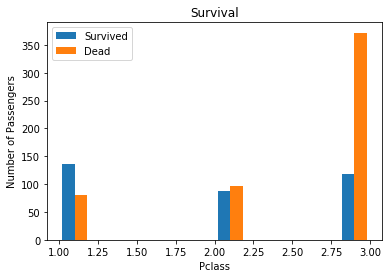

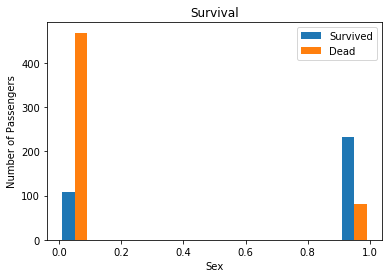

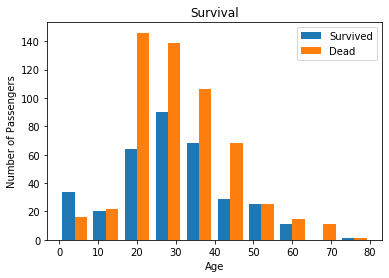

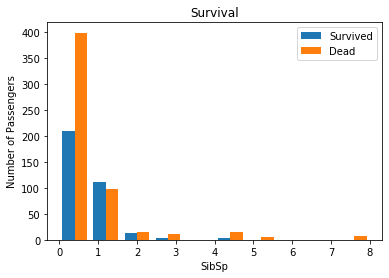

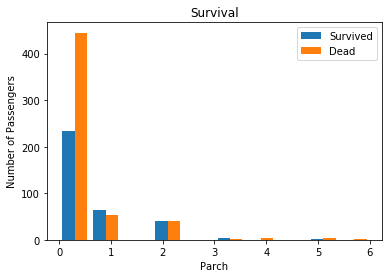

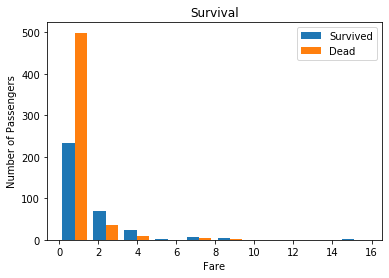

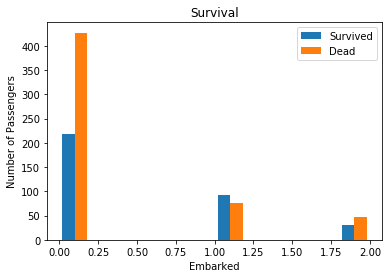

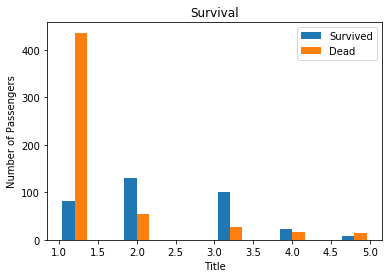

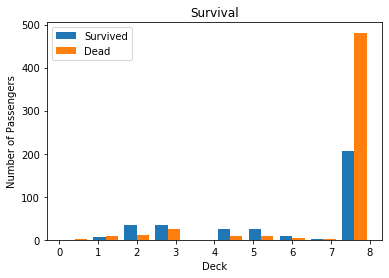

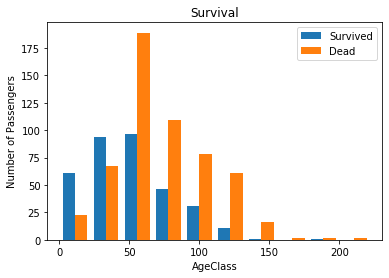

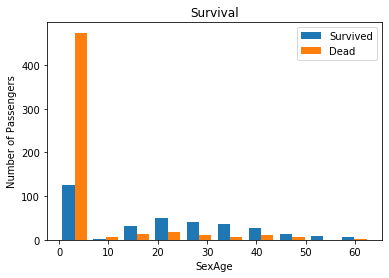

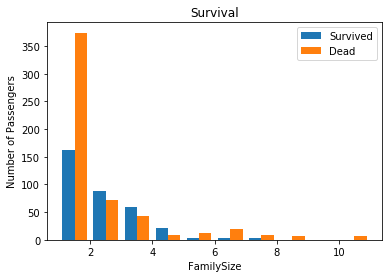

In [22]:
showData(train_x,train_df)

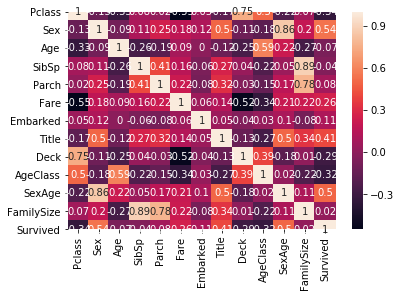

In [23]:
mat = train_x.copy()
mat ['Survived' ] = train_y.astype(int)

correlation_matrix = mat.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [24]:
#Logistic Regression:
from IPython.display import clear_output
clear_output(wait=True)

logreg = LogisticRegression().fit(train_x, train_y)

Y_pred = logreg.predict(test_x)

acc_log = round(logreg.score(train_x, train_y) * 100, 2)
print(acc_log)

82.15


/home/urvi/anaconda3/envs/oops/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
#K Nearest Neighbor:

knn = KNeighborsClassifier(n_neighbors = 3).fit(train_x, train_y)  

Y_pred = knn.predict(test_x)  

acc_knn = round(knn.score(train_x, train_y) * 100, 2)
print(acc_knn)

87.99


In [26]:
#Decision Tree:

decision_tree = DecisionTreeClassifier().fit(train_x, train_y)  

Y_pred = decision_tree.predict(test_x)  

acc_decision_tree = round(decision_tree.score(train_x, train_y) * 100, 2)
print(acc_decision_tree)

98.65


In [27]:
#Linear Support Vector Machine:

linear_svc = LinearSVC().fit(train_x, train_y) 

Y_pred = linear_svc.predict(test_x)

acc_linear_svc = round(linear_svc.score(train_x, train_y) * 100, 2)
print(acc_linear_svc)

47.59


/home/urvi/anaconda3/envs/oops/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [28]:
#Gaussian Naive Bayes:

gaussian = GaussianNB().fit(train_x, train_y) 

Y_pred = gaussian.predict(test_x)  

acc_gaussian = round(gaussian.score(train_x, train_y) * 100, 2)
print(acc_gaussian)

78.34


In [29]:
#Perceptron:

perceptron = Perceptron(max_iter=10).fit(train_x, train_y) 

Y_pred = perceptron.predict(test_x)

acc_perceptron = round(perceptron.score(train_x, train_y) * 100, 2)
print(acc_perceptron)

74.64


/home/urvi/anaconda3/envs/oops/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [30]:
#Random Forest:

from IPython.display import clear_output
clear_output(wait=True)

random_forest = RandomForestClassifier(n_estimators=100, oob_score=True).fit(train_x, train_y) 

Y_prediction = random_forest.predict(test_x)

acc_random_forest = round(random_forest.score(train_x, train_y) * 100, 2)
oob_score = round(random_forest.oob_score_, 4)*100
print(acc_random_forest, oob_score)

98.54 80.25


In [31]:
from sklearn.metrics import roc_auc_score

y_scores = random_forest.predict_proba(train_x)
y_scores = y_scores[:,1]
r_a_score = roc_auc_score(train_y, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9992676743467656


In [32]:
importances = pd.DataFrame({'feature':train_x.columns,'importance':np.round(random_forest.feature_importances_,4)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances.head(12)

,importance
feature,
Fare,0.1796
AgeClass,0.1426
SexAge,0.1364
Title,0.1343
Age,0.1079
Sex,0.0750
Pclass,0.0567
FamilySize,0.0462
Deck,0.0446


In [33]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(8)

,Model
Score,
98.65,Decision Tree
98.54,Random Forest
87.99,KNN
82.15,Logistic Regression
78.34,Naive Bayes
74.64,Perceptron
47.59,Support Vector Machines
